# Primary Roles of Survey Respondents 

* Goal: Extract primary roles of respondents from responses to the survey question: **"What is your primary role when using Jupyter Notebook (e.g., student, astrophysicist, financial modeler, business manager, etc.)?"**
* Data: Output from 2_clean_survey.ipynb notebook (`survey_short_columns.csv`)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option('max_colwidth', 1000)
pd.set_option('max_rows', 200)

In [5]:
df = pd.read_csv('survey_short_columns.csv')

In [6]:
responses = df.role

In [7]:
responses.isnull().value_counts()

True     965
False    741
Name: role, dtype: int64

43% of respondents provided a primary role.

In [8]:
len(responses[responses.isnull() == False]) / len(df)

0.4343493552168816

In [9]:
responses = responses.dropna()

## Initial Samples

I ran the sampling code below several times and manually built up the initial set of role keywords based on common occurrence. I formed groups of conceptually related keywords. Then I tried to assign a simple label to each group.

Make sure the samples come up the same for anyone that re-runs this.

In [10]:
rs = np.random.RandomState(123)

In [11]:
responses.sample(20, random_state=rs)

480                                                  data scientist
1700                                               bioinformatician
325                                                         student
1554                                                 Astrophysicist
398                    University professor (research and teaching)
1400                                                      Developer
1402                                                 data scientist
540                                                  bioinformatics
460                                             Business researcher
254                                                  data scientist
430                                                    personal use
96                                           research meteorologist
1100    Developer of new deep learning, machine learning algorithms
1564                                                      scientist
472                          phd student, astrop

In [12]:
roles = {
    'data_scientist': ['data(\s|-)scien(ce|tist)', 'data analys(t|is)', 'data explorer', 'ml($|\W)', 
                       'machine learning', ],
    'student': ['student', 'phd', 'post(\s|-)?doc', ],
    'educator': ['teach(er|ing)', 'professor', 'educator', 'instructor', 'teaching assistant', ],
    'independent': ['personal use', 'hobby?(ist)?', 'tinkerer', 'technologist', 'independent', 
                    'secretary', 'artist', 'consultant', ], 
    'researcher': ['research(er)?', 'r&d($|\W)', ], 
    'developer': ['develop(er|ment)', 'software (engineer|architect)', 'programmer', ],
    'scientist': ['(astro|bio|geo)?physic(s|ist)?', 'physical science', 'neuroscientist', 
                  'bioinformatic(s|ian)', 'biologi(st|cal)', 'ecologi(st|cal)', 'spectroscopist', 
                  'epidemiologist', 'cosmological', 'geoscienc(es|tist)', '^((?!data).)*scientist', ],
    'author': ['author', 'writer', ], 
    'engineer': ['^((?!software).)*engineer', ],
    'marketer': ['market(er|ing)', ], 
    'manager': ['manager', 'leader', 'management', 'director', 'cto($|\W)', ],
    'statistician': ['statistician', 'mathematician', ],
    'financial_analyst': ['financial (model(er|ing)|analyst)', 'economi(c|st)', 
                          'portfolio (analyst|manager)', 'actuary', 
                          'quant($|\W)', ], 
    'presenter': ['presenter', 'demonstrator', 'lecturer', ],
    'analyst': ['^((?!(data|financial)).)*analyst', 'analytics', ],
    'tester': ['test(er|ing)', 'quality assurance', ]
}

## Coverage Improvement

I next ran the code below to associate the role labels with the responses.  I then iterated on running the code below to find reponses without labels.  I expanded the list of keywords and roles above in order to improve coverage.

In [13]:
import re

In [14]:
def keywords_or(text, keywords):
    for keyword in keywords:
        if re.search('(^|\W+){}'.format(keyword), text, re.IGNORECASE):
            return True
    return False

In [15]:
def tag(responses, tags):
    tagged = responses.to_frame()
    tagged['roles'] = ''
    for tag, keywords in tags.items():
        results = responses.map(lambda text: keywords_or(text, keywords))
        tagged.loc[results, 'roles'] += tag + ','
        print(tag, results.sum())
    return tagged

In [16]:
tagged = tag(responses, roles)
tagged.roles.str.count(',').value_counts()

developer 98
scientist 127
student 132
analyst 29
marketer 2
manager 17
financial_analyst 31
statistician 6
researcher 110
engineer 52
tester 6
presenter 8
data_scientist 179
author 2
educator 40
independent 19


1    597
2    114
0     19
3     11
Name: roles, dtype: int64

In [17]:
tagged[tagged.roles.str.len() == 0].sample(15, random_state=rs)

,role,roles
421,education tool provider,
1287,software test automation,
336,data janitor and statical discovering,
1125,business,
229,Image analyser,
110,data curation,
1379,Computatinal Neurosicentist,
201,Digital humanist,
1565,academic,
19,Architect of Service that embeds Jupyter,


## Precision Check

I then studied a sample of responses for each role to see if there were major inaccuracies in their application (e.g., string matches that are too fuzzy).

In [18]:
from IPython.display import display, clear_output

In [19]:
for key in roles:
    clear_output()
    size = min([20, len(tagged[tagged.roles.str.contains(key)])])
    display(tagged[tagged.roles.str.contains(key)].sample(size))
    if input('Showing `{}`. Type Enter to continue, "q" to stop.'.format(key)) == 'q':
        break

,role,roles
155,Developer,"developer,"
1342,software engineer,"developer,"
505,software engineer,"developer,"
361,Programmer,"developer,"
980,Software Engineer,"developer,"
323,Software engineer,"developer,"
399,Programmer,"developer,"
1306,developer,"developer,"
915,software developer,"developer,"
814,Software Developer,"developer,"


Showing `developer`. Type Enter to continue, "q" to stop.q


## Keyword Frequencies

In [20]:
import matplotlib
import seaborn

In [21]:
counts = {}

In [22]:
for role, keywords in roles.items():
    for keyword in keywords:
        hits = responses.map(lambda text: keywords_or(text, [keyword]))
        counts[keyword] = hits.sum()

In [23]:
hist = pd.Series(counts).sort_values()

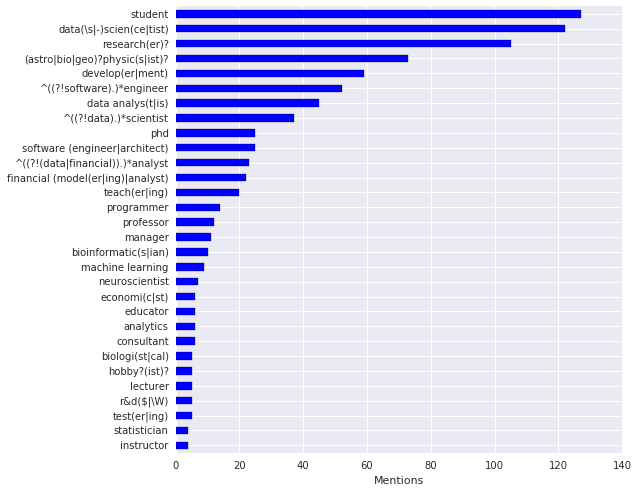

In [24]:
ax = hist[-30:].plot.barh(figsize=(8, 8))
_ = ax.set_xlabel('Mentions')

## Roles and keywords

Add roles and keywords to a DataFrame with the same index as the original so that the entries can be tagged.

In [25]:
column = 'roles'

In [26]:
roles_df = tagged.roles.to_frame()

In [27]:
roles_df = roles_df.rename(columns={'roles' : column+'_roles'})

In [28]:
roles_df[column+'_keywords'] = ''

In [29]:
for role, keywords in roles.items():
    for keyword in keywords:
        results = responses.map(lambda text: keywords_or(text, [keyword]))
        roles_df.loc[results, column+'_keywords'] += keyword + ','

In [30]:
roles_df[column+'_roles'] = roles_df[column+'_roles'].str.rstrip(',')
roles_df[column+'_keywords'] = roles_df[column+'_keywords'].str.rstrip(',')

In [31]:
roles_df.head()

,roles_roles,roles_keywords
1,"scientist,student","(astro|bio|geo)?physic(s|ist)?,student"
5,scientist,(astro|bio|geo)?physic(s|ist)?
6,"financial_analyst,researcher,educator","economi(c|st),research(er)?,professor"
7,"financial_analyst,data_scientist","financial (model(er|ing)|analyst),data analys(t|is)"
9,"developer,researcher","develop(er|ment),research(er)?"


## Assign Primary Role

Some percentage of respondents specified multiple roles, but we would really like to identify a _primary_ role.  If a user responds:

```
bioinformatician, student
```
 
Is the user primarily a scientist or a student?

Start by assigning roles as primary role (since most respondents only have a single role).

In [32]:
roles_df['roles_primary'] = roles_df.roles_roles

A student is a student, regardless of their specified interest or field of study.

In [33]:
roles_df.loc[roles_df.roles_roles.apply(lambda x: 'student' in x.split(',')), 'roles_primary'] = 'student'

Same goes for educators.  If you are in a teaching role, chances are you are also doing research, but you're an educator first.

In [34]:
roles_df.loc[roles_df.roles_roles.apply(lambda x: 'educator' in x.split(',')), 'roles_primary'] = 'educator'

In [35]:
roles_df.head(10)

,roles_roles,roles_keywords,roles_primary
1,"scientist,student","(astro|bio|geo)?physic(s|ist)?,student",student
5,scientist,(astro|bio|geo)?physic(s|ist)?,scientist
6,"financial_analyst,researcher,educator","economi(c|st),research(er)?,professor",educator
7,"financial_analyst,data_scientist","financial (model(er|ing)|analyst),data analys(t|is)","financial_analyst,data_scientist"
9,"developer,researcher","develop(er|ment),research(er)?","developer,researcher"
10,educator,teach(er|ing),educator
11,developer,develop(er|ment),developer
15,financial_analyst,economi(c|st),financial_analyst
17,analyst,analytics,analyst
19,,,


There are not many remaining with multiple roles.

In [36]:
multi_role_index = roles_df[roles_df.roles_primary.str.contains(',')].index
multi_role_index

Int64Index([   7,    9,   34,   37,   79,   98,  109,  143,  153,  154,  165,
             176,  219,  241,  246,  258,  262,  264,  344,  370,  385,  452,
             465,  482,  493,  525,  535,  646,  651,  654,  710,  712,  741,
             765,  766,  771,  824,  828,  859,  873,  904,  940,  966,  987,
            1008, 1022, 1048, 1100, 1122, 1129, 1144, 1212, 1220, 1230, 1333,
            1382, 1383, 1421, 1427, 1453, 1456, 1470, 1557, 1583, 1600, 1601,
            1609, 1691, 1701, 1705],
           dtype='int64')

Time to roll up sleeves.  (This is real data science).

In [37]:
responses[responses.index.isin(multi_role_index)]

7                                                                data analyst, financial modeler
9                                                  Developer in research oriented energy company
34                                                                            Research scientist
37                                                                       Data analyst, developer
79                                                                   Data Scientist (consultant)
98                                                            business analysts / data scientist
109                                                                            portfolio analyst
143                                             Software Engineer helping Atmospheric Scientists
153                                                                        data scientist leader
154                                           Data scientist / engineer in electromagnetic field
165                           

In [58]:
roles_df.loc[7, 'roles_primary'] = 'financial_analyst'
roles_df.loc[9, 'roles_primary'] = 'developer'
roles_df.loc[34, 'roles_primary'] = 'scientist'
roles_df.loc[37, 'roles_primary'] = 'data_scientist'
roles_df.loc[79, 'roles_primary'] = 'data_scientist'
roles_df.loc[98, 'roles_primary'] = 'analyst'
roles_df.loc[109, 'roles_primary'] = 'financial_analyst'
roles_df.loc[143, 'roles_primary'] = 'developer'
roles_df.loc[153, 'roles_primary'] = 'data_scientist'
roles_df.loc[154, 'roles_primary'] = 'data_scientist'
roles_df.loc[165, 'roles_primary'] = 'researcher'
roles_df.loc[176, 'roles_primary'] = 'engineer'
roles_df.loc[219, 'roles_primary'] = 'developer'
roles_df.loc[241, 'roles_primary'] = 'developer'
roles_df.loc[246, 'roles_primary'] = 'researcher'
roles_df.loc[258, 'roles_primary'] = 'engineer'
roles_df.loc[262, 'roles_primary'] = 'researcher'
roles_df.loc[264, 'roles_primary'] = 'analyst'
roles_df.loc[344, 'roles_primary'] = 'scientist'
roles_df.loc[370, 'roles_primary'] = 'researcher'
roles_df.loc[385, 'roles_primary'] = 'manager'
roles_df.loc[452, 'roles_primary'] = 'scientist'
roles_df.loc[465, 'roles_primary'] = 'engineer'
roles_df.loc[482, 'roles_primary'] = 'scientist'
roles_df.loc[493, 'roles_primary'] = 'engineer'
roles_df.loc[525, 'roles_primary'] = 'developer'
roles_df.loc[535, 'roles_primary'] = 'engineer'
roles_df.loc[646, 'roles_primary'] = 'researcher'
roles_df.loc[651, 'roles_primary'] = 'data_scientist'
roles_df.loc[654, 'roles_primary'] = 'scientist'
roles_df.loc[710, 'roles_primary'] = 'financial_analyst'
roles_df.loc[712, 'roles_primary'] = 'scientist'
roles_df.loc[741, 'roles_primary'] = 'researcher'
roles_df.loc[765, 'roles_primary'] = 'developer'
roles_df.loc[766, 'roles_primary'] = 'engineer'
roles_df.loc[771, 'roles_primary'] = 'data_scientist'
roles_df.loc[824, 'roles_primary'] = 'scientist'
roles_df.loc[828, 'roles_primary'] = 'data_scientist'
roles_df.loc[859, 'roles_primary'] = 'developer'
roles_df.loc[873, 'roles_primary'] = 'scientist'
roles_df.loc[904, 'roles_primary'] = 'data_scientist'
roles_df.loc[940, 'roles_primary'] = 'engineer'
roles_df.loc[966, 'roles_primary'] = 'data_scientist'
roles_df.loc[987, 'roles_primary'] = 'developer'
roles_df.loc[1008, 'roles_primary'] = 'presenter'
roles_df.loc[1022, 'roles_primary'] = 'developer'
roles_df.loc[1048, 'roles_primary'] = 'researcher'
roles_df.loc[1100, 'roles_primary'] = 'data_scientist'
roles_df.loc[1122, 'roles_primary'] = 'developer'
roles_df.loc[1129, 'roles_primary'] = 'manager'
roles_df.loc[1144, 'roles_primary'] = 'developer'
roles_df.loc[1212, 'roles_primary'] = 'engineer'
roles_df.loc[1220, 'roles_primary'] = 'engineer'
roles_df.loc[1230, 'roles_primary'] = 'developer'
roles_df.loc[1333, 'roles_primary'] = 'scientist'
roles_df.loc[1382, 'roles_primary'] = 'researcher'
roles_df.loc[1383, 'roles_primary'] = 'scientist'
roles_df.loc[1421, 'roles_primary'] = 'data_scientist'
roles_df.loc[1427, 'roles_primary'] = 'analyst'
roles_df.loc[1453, 'roles_primary'] = 'developer'
roles_df.loc[1456, 'roles_primary'] = 'researcher'
roles_df.loc[1470, 'roles_primary'] = 'data_scientist'
roles_df.loc[1557, 'roles_primary'] = 'developer'
roles_df.loc[1583, 'roles_primary'] = 'manager'
roles_df.loc[1600, 'roles_primary'] = 'engineer'
roles_df.loc[1601, 'roles_primary'] = 'data_scientist'
roles_df.loc[1609, 'roles_primary'] = 'scientist'
roles_df.loc[1691, 'roles_primary'] = 'researcher'
roles_df.loc[1701, 'roles_primary'] = 'developer'
roles_df.loc[1705, 'roles_primary'] = 'developer'

Sanity check.

In [61]:
assert all(list(roles_df.apply(lambda x: x.roles_primary in x.roles_roles.split(','), axis=1)))

## Persist

We'll write a semi-colon separated file for easy of reading in other tools.

In [62]:
roles_df.to_csv('roles.csv', sep=';')

If we want to recover the same DataFrame later, we can use this code.

In [63]:
tmp = pd.read_csv('roles.csv', sep=';', index_col=0).fillna('')